@everywhere using Printf, LinearAlgebra
@everywhere using WriteVTK, Distributed
@everywhere using AbaqusReader, PyCall, JLD

@everywhere include("adiff.jl")
@everywhere include("materials.jl")
@everywhere include("elements.jl")

Elements.setp(16)

In [1]:
using LinearAlgebra, Statistics
using Printf, WriteVTK, Distributed
using AbaqusReader, PyCall, PyPlot, JLD

In [2]:
include("adiff.jl")
include("materials.jl")
include("elements.jl")

@show Elements.setp(16)
;

Elements.setp(16) = 16


In [3]:
function sort_bnd(nodes, nid_bnd)
  closest(node0, nodes) = findmin([norm(node0-node) for node in nodes])[2]

  id_srtd   = [nid_bnd[1],]
  lastnode  = nid_bnd[1]
  bnd_nodes = nid_bnd[2:end]

  while !isempty(bnd_nodes)
    idd = closest(nodes[lastnode], nodes[bnd_nodes])
    lastnode = bnd_nodes[idd]
    push!(id_srtd, bnd_nodes[idd])
    deleteat!(bnd_nodes, idd)
  end

  push!(id_srtd, id_srtd[1])
end
function Area(nodes)
  x = vcat(nodes[1:2:end], nodes[1])
  y = vcat(nodes[2:2:end], nodes[2])
  1/2*sum( (y[2:end]-y[1:end-1]).*(x[2:end]+x[1:end-1]) ) -  
  1/2*sum( (y[2:end]+y[1:end-1]).*(x[2:end]-x[1:end-1]) )
end
function Volume(nodes)
  # x,y = nodes[1:2:end],nodes[2:2:end]
  x   = vcat(nodes[1:2:end], nodes[1])
  y   = vcat(nodes[2:2:end], nodes[2])
  Δy  = y[2:end] .- y[1:end-1]
  xs  = x[2:end] .+ x[1:end-1]
  xp  = x[2:end] .* x[1:end-1]
 
  sum( Δy.*(xs.^2 .- xp) )*(π/3)
end
;

In [4]:
sMeshFile	= "AxSymDomain04_02.inp"
mat			= Materials.NeoHooke(10)
bisinc      = true
Δy 			= -6
sPosFix		= "NHd"
;

In [5]:
Nsteps		= 10
LF 			= range(1/100Nsteps,1,length=Nsteps)
dTol		= 1e-3
maxiter		= 31
sVTKpath	= "./vtk_files/"
bwarmup		= true
bVTKall		= true
ballus		= true
becho		= true
bechoi		= true
bprogress	=!becho
;

		starting AxSymDomain04_02NHd ... 




┌ Info: 2791 nodes found
└ @ AbaqusReader /u1/vian294/.julia/packages/AbaqusReader/sDEH0/src/parse_mesh.jl:103
┌ Info: Parsing elements. Type: CPS4. Topology: Quad4
└ @ AbaqusReader /u1/vian294/.julia/packages/AbaqusReader/sDEH0/src/parse_mesh.jl:147
┌ Info: Creating nset TOP
└ @ AbaqusReader /u1/vian294/.julia/packages/AbaqusReader/sDEH0/src/parse_mesh.jl:181
┌ Info: Creating elset TOP
└ @ AbaqusReader /u1/vian294/.julia/packages/AbaqusReader/sDEH0/src/parse_mesh.jl:181
┌ Info: Creating nset BTM
└ @ AbaqusReader /u1/vian294/.julia/packages/AbaqusReader/sDEH0/src/parse_mesh.jl:181
┌ Info: Creating elset BTM
└ @ AbaqusReader /u1/vian294/.julia/packages/AbaqusReader/sDEH0/src/parse_mesh.jl:181
┌ Info: Creating nset BND
└ @ AbaqusReader /u1/vian294/.julia/packages/AbaqusReader/sDEH0/src/parse_mesh.jl:181
┌ Info: Creating elset BND
└ @ AbaqusReader /u1/vian294/.julia/packages/AbaqusReader/sDEH0/src/parse_mesh.jl:181
┌ Info: Creating nset ALL
└ @ AbaqusReader /u1/vian294/.julia/packages/Aba

(nNodes, nElems) = (length(nodes), length(elems)) = (2791, 2570)


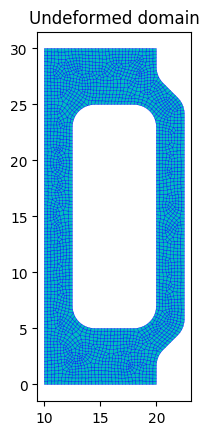

In [6]:
sFileName = splitext(sMeshFile)[1]*sPosFix
@printf("\t\tstarting %s ... \n\n\n", sFileName); flush(stdout)


mymodel   = AbaqusReader.abaqus_read_mesh(sMeshFile)
nodes     = [mymodel["nodes"][ii] for ii in 1:mymodel["nodes"].count]
el_nodes  = [item[2]              for item in mymodel["elements"]] 

nid_btm   = mymodel["node_sets"]["BTM"]
nid_top   = mymodel["node_sets"]["TOP"]
nid_bnd   = mymodel["node_sets"]["BND"]

elems     = []
for item ∈ el_nodes
if length(item)==3
  push!(elems, Elements.ASTria(item, nodes[item], mat=mat))
elseif length(item)==4
  push!(elems, Elements.ASQuad(item, nodes[item], mat=mat))
end
end    

points    = hcat(nodes...)
cells     = [if length(nodes)==3
             MeshCell(VTKCellTypes.VTK_TRIANGLE, nodes)
           else length(nodes)==4
             MeshCell(VTKCellTypes.VTK_QUAD, nodes)
           end  for nodes in el_nodes ]
                
@show (nNodes, nElems) = (length(nodes), length(elems)); flush(stdout)
                
Elements.plot_model(elems, nodes)
PyPlot.title("Undeformed domain")
;

In [7]:
id_srtd   = sort_bnd(nodes, nid_bnd);        
pos0      = hcat(nodes[id_srtd]...)[:]
idx0      = LinearIndices((2,nNodes))[:,id_srtd]
@show V0  = Volume(pos0)

eqns = [Elements.ConstEq(x->Volume(pos0+x)-V0, 
                       LinearIndices((2,nNodes))[:,id_srtd][:], adiff.D1)]
if bisinc
    eqns = push!(eqns,
             [Elements.ConstEq(x->elem.V*(Elements.getJ(Elements.getF(elem, x))-1), 
                               LinearIndices((2,nNodes))[:,elem.nodes][:], adiff.D2)
              for elem in elems]...)
end
;

V0 = Volume(pos0) = -14959.414796647612


In [8]:
# displacement boundary conditions
u    = fill!(zeros(2, nNodes), NaN)
f    = zeros(2, nNodes)

u[:, nid_btm] .= 0
u[2, nid_top] .= Δy 
;

In [9]:
if bwarmup
    bfreeu     = isnan.(u)
    u0         = 1e-4copy(u)
    u0[bfreeu] .= 0

    @time (bfailed, normr, iter) = Elements.solvestep!(elems, 
        u0, bfreeu, bprogress=true, becho=false, maxiter = 21, dTol=1e-4, eqns=eqns)
end
;                

Progress:  Time: 0:02:44 (3 iterations)


169.820274 seconds (64.62 M allocations: 8.675 GiB, 1.54% gc time)



iter:  1, norm0: 4.66e+03, normr/dTol: 2.66e+03, eltime: 1.51 sec. 
iter:  2, norm0: 4.71e+03, normr/dTol: 1.31e+01, eltime: 2.40 sec. 
iter:  3, norm0: 4.70e+03, normr/dTol: 2.25e-02, eltime: 1.08 sec. 
step  1 done in  3 iter, after 5.49 sec.

iter:  1, norm0: 5.40e+03, normr/dTol: 1.42e+03, eltime: 2.95 sec. 
iter:  2, norm0: 4.69e+03, normr/dTol: 1.39e+01, eltime: 2.83 sec. 
iter:  3, norm0: 4.68e+03, normr/dTol: 7.87e-01, eltime: 1.18 sec. 
step  2 done in  3 iter, after 6.96 sec.

iter:  1, norm0: 5.41e+03, normr/dTol: 1.42e+03, eltime: 2.64 sec. 
iter:  2, norm0: 4.66e+03, normr/dTol: 1.47e+01, eltime: 2.72 sec. 
iter:  3, norm0: 4.66e+03, normr/dTol: 9.56e-01, eltime: 1.00 sec. 
step  3 done in  3 iter, after 6.36 sec.

iter:  1, norm0: 5.42e+03, normr/dTol: 1.41e+03, eltime: 2.38 sec. 
iter:  2, norm0: 4.64e+03, normr/dTol: 1.48e+01, eltime: 2.77 sec. 
iter:  3, norm0: 4.65e+03, normr/dTol: 1.17e+00, eltime: 2.48 sec. 
iter:  4, norm0: 4.65e+03, normr/dTol: 1.44e-02, eltime: 

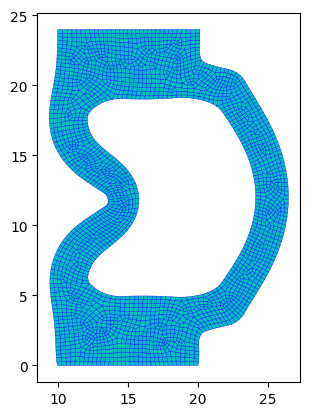

results written to AxSymDomain04_02NHd


In [10]:
allus_d = Elements.solve(elems, u, fe=f, eqns=eqns, LF=LF,
                     becho=becho, bechoi=bechoi, ballus=ballus, bprogress=bprogress,
                     dTol=dTol, maxiter=maxiter)

Elements.plot_model(elems, nodes, u = allus_d[end][1])

rf_tot = [sum(item[2][2, nid_top])  for item in allus_d]
Δu_tot = [mean(item[1][2,nid_top])  for item in allus_d]
##
JLD.save(sFileName*".jld", "nodes", nodes, "elems", elems, "allus", allus_d,
       "points", points, "cells", cells, "LF", LF, "mat", mat,
       "Nsteps", Nsteps, "nid_btm", nid_btm, "nid_top", nid_top, "nid_bnd", nid_bnd,
       "rf_tot", rf_tot, "Δu_tot", Δu_tot, "sFileName", sFileName)

@printf("results written to %s\n", sFileName);
;

In [11]:
Δy 			= 6
Nsteps		= 10
sPosFix		= "NHu"
LF 			= range(1/100Nsteps,1,length=Nsteps)

# displacement boundary conditions
u    = fill!(zeros(2, nNodes), NaN)
f    = zeros(2, nNodes)

u[:, nid_btm] .= 0
u[2, nid_top] .= Δy 
;


iter:  1, norm0: 4.75e+03, normr/dTol: 2.61e+03, eltime: 2.43 sec. 
iter:  2, norm0: 4.70e+03, normr/dTol: 1.31e+01, eltime: 3.23 sec. 
iter:  3, norm0: 4.70e+03, normr/dTol: 2.28e-02, eltime: 1.02 sec. 
step  1 done in  3 iter, after 6.69 sec.

iter:  1, norm0: 1.14e+04, normr/dTol: 6.74e+02, eltime: 2.65 sec. 
iter:  2, norm0: 4.76e+03, normr/dTol: 5.31e+00, eltime: 3.41 sec. 
iter:  3, norm0: 4.73e+03, normr/dTol: 7.09e-02, eltime: 1.32 sec. 
step  2 done in  3 iter, after 7.38 sec.

iter:  1, norm0: 1.14e+04, normr/dTol: 6.72e+02, eltime: 2.56 sec. 
iter:  2, norm0: 4.79e+03, normr/dTol: 5.05e+00, eltime: 3.85 sec. 
iter:  3, norm0: 4.76e+03, normr/dTol: 7.13e-02, eltime: 1.20 sec. 
step  3 done in  3 iter, after 7.61 sec.

iter:  1, norm0: 1.14e+04, normr/dTol: 6.69e+02, eltime: 3.30 sec. 
iter:  2, norm0: 4.82e+03, normr/dTol: 4.76e+00, eltime: 2.64 sec. 
iter:  3, norm0: 4.78e+03, normr/dTol: 6.99e-02, eltime: 1.04 sec. 
step  4 done in  3 iter, after 6.98 sec.

iter:  1, norm0

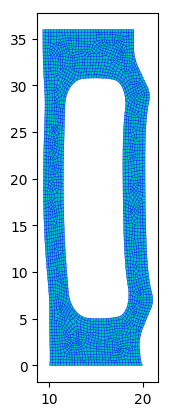

In [12]:
allus_u = Elements.solve(elems, u, fe=f, eqns=eqns, LF=LF,
                     becho=becho, bechoi=bechoi, ballus=ballus, bprogress=bprogress,
                     dTol=dTol, maxiter=maxiter)
Elements.plot_model(elems, nodes, u = allus_u[end][1])


rf_tot = [sum(item[2][2, nid_top])  for item in allus_u]
Δu_tot = [mean(item[1][2,nid_top])  for item in allus_u]
##
JLD.save(sFileName*".jld", "nodes", nodes, "elems", elems, "allus", allus_u,
       "points", points, "cells", cells, "LF", LF, "mat", mat,
       "Nsteps", Nsteps, "nid_btm", nid_btm, "nid_top", nid_top, "nid_bnd", nid_bnd,
       "rf_tot", rf_tot, "Δu_tot", Δu_tot, "sFileName", sFileName)
@printf("results written to %s\n", sFileName); flush(stdout)

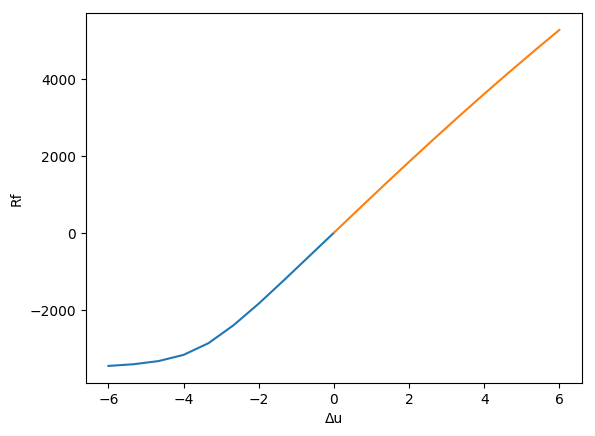

In [13]:
rf_tot_u = [sum(item[2][2, nid_top])  for item in allus_u]
Δu_tot_u = [mean(item[1][2,nid_top])  for item in allus_u]
rf_tot_d = [sum(item[2][2, nid_top])  for item in allus_d]
Δu_tot_d = [mean(item[1][2,nid_top])  for item in allus_d]

PyPlot.plot(Δu_tot_d, rf_tot_d, Δu_tot_u, rf_tot_u)
PyPlot.ylabel("Rf")
PyPlot.xlabel("Δu")
;